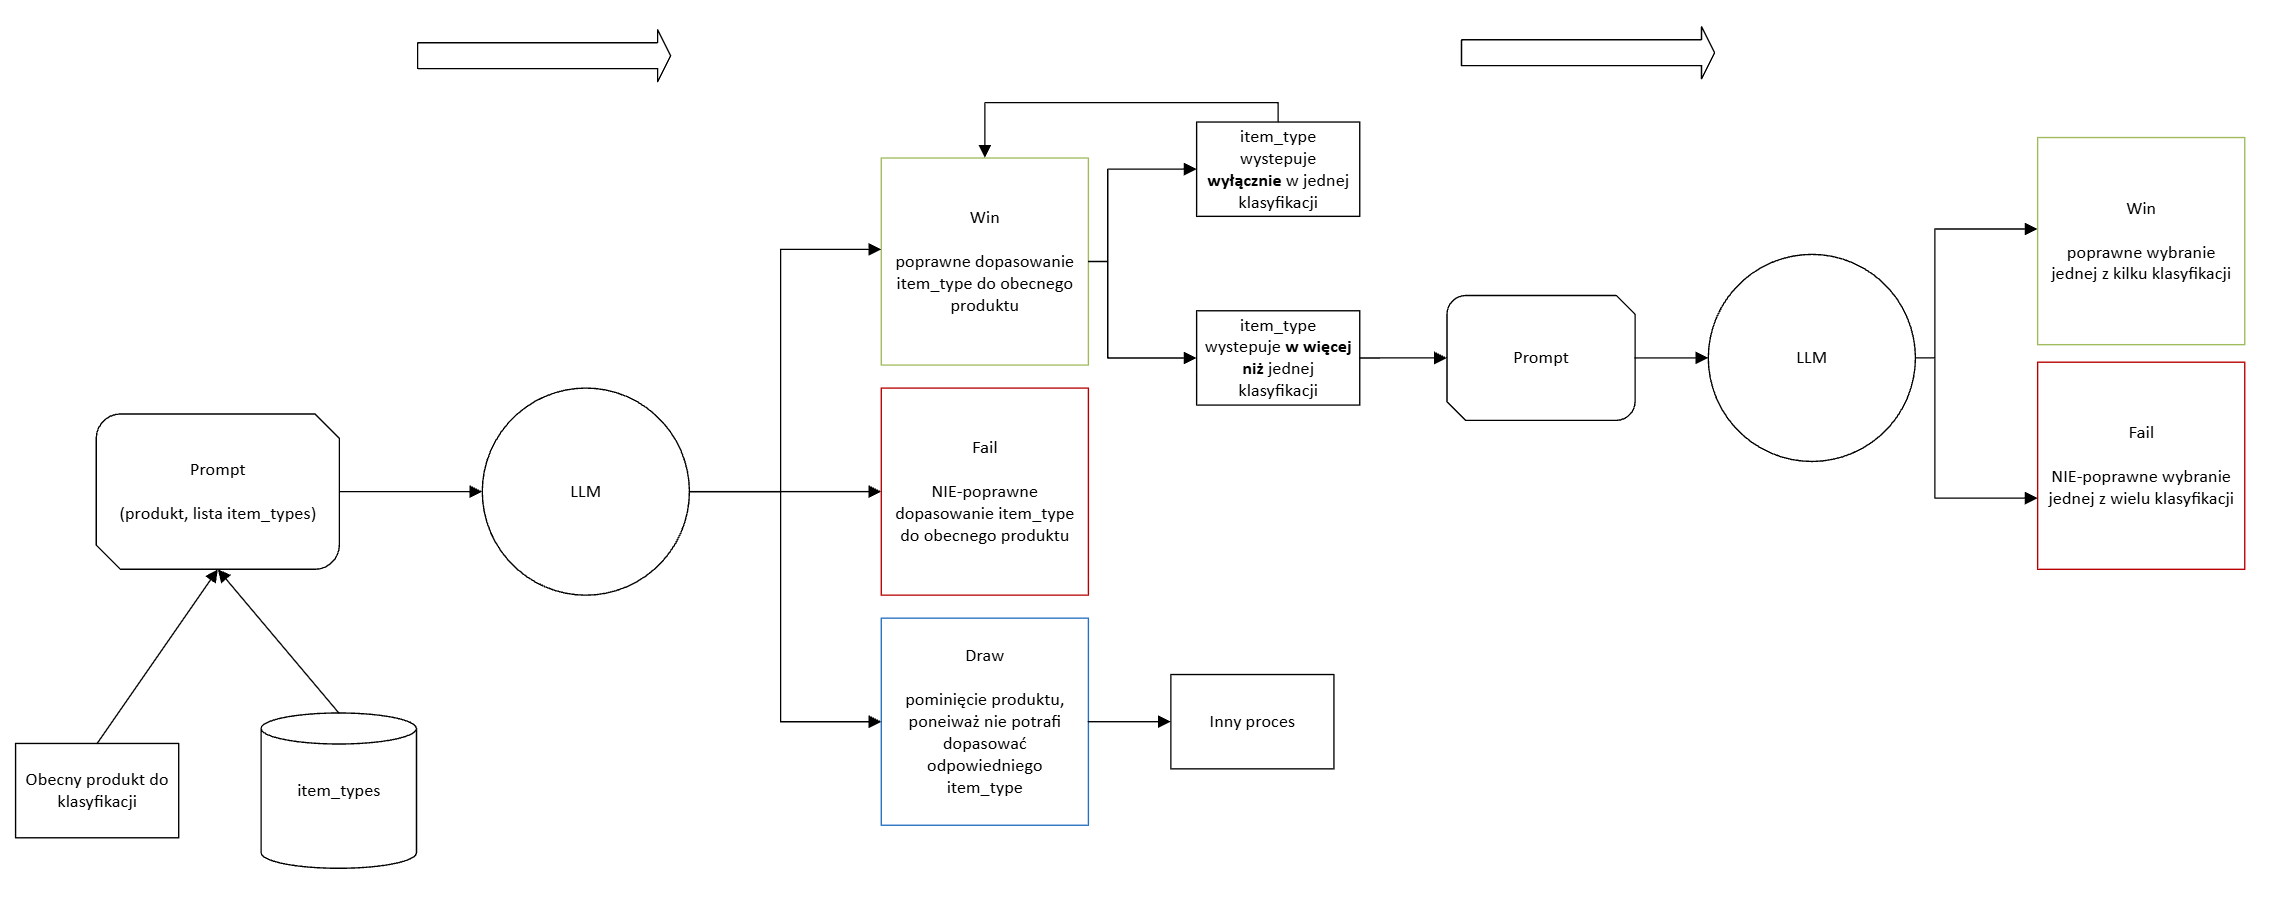

In [1]:
import warnings
import requests
import json
import pandas as pd
from utils import ask_openai
from tqdm import tqdm


warnings.filterwarnings("ignore")

# Data

In [2]:
MAIN_CLASSES = [
    "Furniture",
    "Lighting",
    "Home Textiles",
    "Tableware",
    "Decoration",
    "Flowers & Plants"
]
TEST_ROWS = 100
OPEN_ROUTER_FILEPATH = "../open_router_api_key.txt"

In [3]:
df = pd.read_csv("../resources/item data 2026_AW(Sheet1).csv", sep=",")
df = df[df["main"].isin(MAIN_CLASSES)]

for col in ["main", "sub", "detail", "level4", "item_type"]:
    df[col].fillna("Unspecified", inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4054 entries, 0 to 4267
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   item_id                         4054 non-null   int64  
 1   supplier_id                     4054 non-null   int64  
 2   supplier_name                   4054 non-null   object 
 3   season                          4054 non-null   object 
 4   supplier_reference              4054 non-null   object 
 5   supplier_reference_description  4054 non-null   object 
 6   purchase_price                  4054 non-null   float64
 7   length                          3893 non-null   float64
 8   width                           3870 non-null   float64
 9   height                          3832 non-null   float64
 10  weight                          3378 non-null   float64
 11  hscode6                         3684 non-null   float64
 12  hscode10                        2514 no

# Utils

In [4]:
def get_openrouter_api_key() -> str:
    with open(OPEN_ROUTER_FILEPATH, "r") as file:
        api_key = file.read()
    return api_key

In [5]:
def ask_openai(prompt: str, model_id: str = "openai/gpt-4o-mini") -> str:
  response = requests.post(
    url="https://openrouter.ai/api/v1/chat/completions",
    headers={
      "Authorization": f"Bearer {get_openrouter_api_key()}",
      "Content-Type": "application/json",
    },
    data=json.dumps({
      "model": model_id,
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ]
    })
  )

  if response.status_code == 200:
    return response.json()["choices"][0]["message"]["content"]
  else:
    raise ValueError(f"{response.status_code}: {response.text}")

In [6]:
class ClassificationTree:

    def __init__(self, df: pd.DataFrame):
        self.tree = (
            df
            .groupby(["main", "sub", "detail", "level4"])
            .agg({"item_id": "nunique"})
            .drop("item_id", axis=1)
            .reset_index()
        )
        self.map_by_item_type = self.prepare_item_types_map()

    def get_classifications_by_item_type(self, item_type: str) -> list[dict[str, str]]:
        return self.map_by_item_type[item_type]
    
    def get_item_types(self) -> list[str]:
        return list(self.map_by_item_type.keys())

    def get_main_options(self) -> list[str]:
        return list(self.tree["main"].unique())
    
    def get_sub_options(self, main: str) -> list[str]:
        return list(
            self.tree
            [self.tree["main"] == main]
            ["sub"]
            .unique()
        )

    def get_detail_options(self, sub: str) -> list[str]:
        return list(
            self.tree
            [self.tree["sub"] == sub]
            ["detail"]
            .unique()
        )

    def get_level4_options(self, detail: str) -> list[str]:
        return list(
            self.tree
            [self.tree["detail"] == detail]
            ["level4"]
            .unique()
        )
    
    def prepare_item_types_map(self) -> dict[str, list[dict[str, str]]]:
        unique_item_types = df["item_type"].unique()
        item_types_map = {}

        for item_type in unique_item_types:
            rows = (
                df
                [df["item_type"] == item_type]
                .drop_duplicates(subset=["main", "sub", "detail", "level4"])
                [["main", "sub", "detail", "level4"]]
            )
            item_types_map[item_type] = [
                rows.iloc[i].to_dict()
                for i in range(len(rows))
            ]
        return item_types_map

In [7]:
def train_test_split(raw_df: pd.DataFrame):
    # fill na
    df = raw_df[raw_df["main"].isin(MAIN_CLASSES)]
    for col in ["main", "sub", "detail", "level4"]:
        df[col] = df[col].fillna("Unspecified")
    
    ratios = df["main"].value_counts(normalize=True).to_dict()

    df = df.sample(len(df)) # shuffle data
    test_df = pd.DataFrame()


    for main_class, ratio in ratios.items():
        new_df = df[df["main"] == main_class].sample(int(TEST_ROWS*ratio))
        test_df = pd.concat([test_df, new_df])

    if len(test_df) < TEST_ROWS:
        diff = TEST_ROWS - len(test_df)
        test_df = pd.concat([
            test_df,
            df[~(df["item_id"].isin(test_df["item_id"]))].sample(diff)
        ])

    train_df = df[~(df["item_id"].isin(test_df["item_id"]))]

    return test_df, train_df

In [8]:
def row_to_text_input(df: pd.DataFrame, i: int) -> str:
    text = f"""
    Supplier name = {df["supplier_name"].iloc[i]}
    Product name = {df["supplier_reference_description"].iloc[i]}
    Product price = {df["purchase_price"].iloc[i]}
    """
    return text

# Prompts templates

In [9]:
find_item_type = """
<system>
    You are an assitant that helps with product categorization. 
    Products are typically realted with house, home, garden items.
</system>


<task>
    1. Analyze the given product described in a "product" tag. 
    2. Try to find the best category in the "categories" tag.
</task>


<product>
    {product}
</product>


<categories>
    {categories}
</categories>


<rules>
    1. If you are completely sure that any category is appropraite, return this category without any extra text. Only this category as a plain text.
    2. Otherwise,  if you're not 100% sure, return nothing, empty value. 
    3. Do not add any extra and unneccessary things, intros, endings.
</rules>
"""

In [10]:
choose_classification = """
<system>
    You are an assitant that helps with product categorization. 
    Products are typically realted with house, home, garden items.
</system>


<task>
    1. Analyze the given product described in a "product" tag. 
    2. Choose the best classification in the "options" tag.
</task>


<product>
    {product}
</product>


<options>
    {options}
</options>


<rules>
    1. Return only the numerical id of option you want to choose.
    2. Do not add any extra things.
</rules>
"""

# Demo

In [11]:
test_df, train_df = train_test_split(df)

In [12]:
len(test_df)

100

In [13]:
len(train_df)

3954

In [14]:
classification_tree_train = ClassificationTree(train_df)
classification_tree_test = ClassificationTree(test_df)

In [29]:
results = []


for i in tqdm(range(len(test_df))):
    win, fail, draw, llm_error = False, False, False, False
    real_classification = None
    real_item_type = None
    classification = None
    ai_answer = None

    product = row_to_text_input(test_df, i)
    categories = classification_tree_train.get_item_types()
    prompt = find_item_type.format(
        product=product,
        categories=categories
    )
    ai_answer = ask_openai(prompt)

    # print(f"Product:\n{product}\n")
    if ai_answer:
        try:
            potential_classifications = classification_tree_train.get_classifications_by_item_type(ai_answer)
        except KeyError:
            llm_error = True
            continue


        if len(potential_classifications) == 1:
            classification = potential_classifications[0]
        else:
            prompt = choose_classification.format(
                product=product,
                options={
                    i: potential_classifications[i]
                    for i in range(len(potential_classifications))
                }
            )
            idx = ask_openai(prompt)

            try:
                classification = potential_classifications[int(idx)]
            except:
                llm_error = True
                continue
        
        real_classification = (
            test_df
            .iloc[i]
            [["main", "sub", "detail", "level4"]]
            .to_dict()
        )
        real_item_type = (
            test_df
            .iloc[i]
            ["item_type"]
        )

        if real_classification == classification:
            # print(f"{ai_answer}: Success!\n{classification}\n\n\n")
            win = True
        else:
            # print(f"Failure!\nReal {real_item_type}: {real_classification},\nPredicted {ai_answer}: {classification}\n\n\n")
            fail = True

    else:
        # print("There is no matching item type")
        draw = True
    
    results.append(
        dict(
            win=win,
            fail=fail,
            draw=draw,
            real_classification=real_classification,
            real_item_type=real_item_type,
            pred_classification=classification,
            pred_item_type=ai_answer
        )
    )


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


In [30]:
results_df = pd.DataFrame(results)

In [33]:
print(len(results_df[results_df["win"]]))
results_df[results_df["win"]]

56


,win,fail,draw,real_classification,real_item_type,pred_classification,pred_item_type
0,True,False,False,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Candle holder,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Candle holder
2,True,False,False,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Candle holder,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Candle holder
4,True,False,False,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Vase,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Vase
5,True,False,False,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Garland,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Garland
8,True,False,False,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Vase,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Vase
10,True,False,False,"{'main': 'Decoration', 'sub': 'Home Fragrances...",Scented candle,"{'main': 'Decoration', 'sub': 'Home Fragrances...",Scented candle
12,True,False,False,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Tealight holder,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Candle holder
13,True,False,False,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Hanger,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Hanger
14,True,False,False,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Flowerpot,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Flowerpot
15,True,False,False,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Unspecified,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Vase


In [34]:
print(len(results_df[results_df["fail"]]))
results_df[results_df["fail"]]

35


,win,fail,draw,real_classification,real_item_type,pred_classification,pred_item_type
1,False,True,False,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Floor vase,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Bottle
3,False,True,False,"{'main': 'Decoration', 'sub': 'Wall Decoration...",Unspecified,"{'main': 'Decoration', 'sub': 'Photo Frames', ...",Photo frame
7,False,True,False,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Candle holder,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Vase
9,False,True,False,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Bird + Clip,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Bird
11,False,True,False,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Leaf,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Abstract Decoration
27,False,True,False,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Flowerpot,"{'main': 'Furniture', 'sub': 'Tables', 'detail...",Side table
28,False,True,False,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Candle,"{'main': 'Decoration', 'sub': 'Home Fragrances...",Scented candle
29,False,True,False,"{'main': 'Decoration', 'sub': 'Flower Pots & V...",Vase,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Bottle
31,False,True,False,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Wreath,"{'main': 'Flowers & Plants', 'sub': 'Unspecifi...",Unspecified
33,False,True,False,"{'main': 'Decoration', 'sub': 'Candles & Candl...",Tealight holder,"{'main': 'Decoration', 'sub': 'Home Accessorie...",Decorative bell jar


In [35]:
print(len(results_df[results_df["draw"]]))
results_df[results_df["draw"]]

9


,win,fail,draw,real_classification,real_item_type,pred_classification,pred_item_type
6,False,False,True,None,None,None,
22,False,False,True,None,None,None,
36,False,False,True,None,None,None,
48,False,False,True,None,None,None,
59,False,False,True,None,None,None,
67,False,False,True,None,None,None,
68,False,False,True,None,None,None,
70,False,False,True,None,None,None,
71,False,False,True,None,None,None,


In [37]:
results_df.to_csv("../resources/item_type_results.csv", index=False)